<a href="https://colab.research.google.com/github/ivan-shargin/cvr_course/blob/main/mnist_sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация рукописных цифр [2]: свёрточные сети

MNIST - датасет из 60000+10000 одноканальных изображений 28x28

Измените среду выполнения на GPU

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



tensor(1)


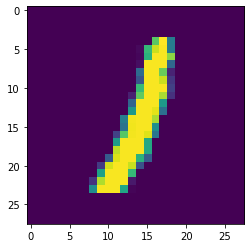

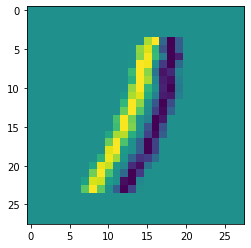

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

for data, target in train_loader:
    for i in range (1):
        print (target [i])
        img = data [i, 0, :, :]
        plt.imshow (img)
        plt.show ()

        #kernel = np.ones((3, 3),np.float32)
        kernel = np.array([[-1, 0, 1]],np.float32)

        #print (type (img))
        convolved = cv2.filter2D(img.detach().cpu().numpy(),-1,kernel)
        plt.imshow (convolved)
        plt.show ()

    break

In [ ]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive, train=True):
    train_loss = 0

    if (train):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    else:
        model.eval()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
         
            train_loss += loss.item ()

            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

# def test(model, device, test_loader, loss_archive):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss = test_loss / len(test_loader)
#     loss_archive.append (test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

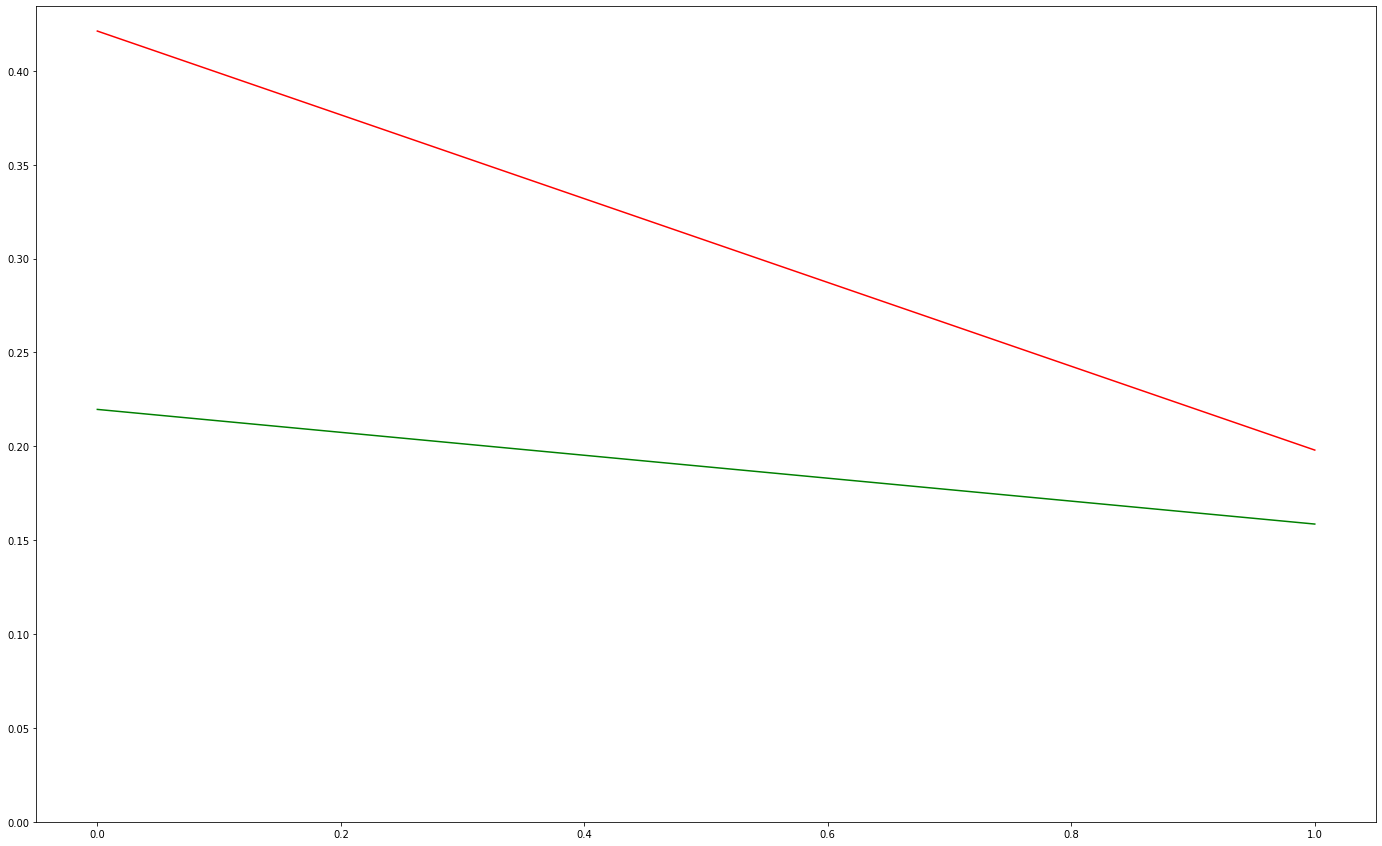

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168252
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.074310
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.132880
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.182919
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.101337
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.207058
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.196817
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.108586
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.125320
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.113869
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.080255


KeyboardInterrupt: ignored

In [ ]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Simple_net(100, 10).to(device)
#model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    train(model, device, test_loader, optimizer, epoch, log_interval, test_loss)

    # test(model, device, test_loader, test_loss)
    
    scheduler.step()

    #clear_output(wait = True)

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

    plt.pause (0.01)